In [2]:
import os, sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from typing import Union, Sequence, Tuple

home = os.getcwd()
current = home
while 'models' not in os.listdir(current):
    current = Path(current).parent

sys.path.append(str(current))

In [3]:
DATA_FOLDER = os.path.join(Path(os.getcwd()).parent, 'data')
print(DATA_FOLDER)

/home/ayhem18/DEV/RecSys/data


In [4]:
# funny enough, there is a package  called uszipcode that can be used to manipulate zip codes in USA
users = pd.read_csv(os.path.join(DATA_FOLDER, 'ml-100k', 'u.user'), sep='|', encoding='latin', header=None)
from uszipcode import SearchEngine 
search = SearchEngine()
users.rename(columns={0:'id', 1: 'age', 2: 'gender', 3:'job', 4: 'zip_code'}, inplace=True)
# this is crucial to fill the missing data
users.sort_values(by='zip_code')

/home/ayhem18/DEV/RecSys/rs_env/lib/python3.11/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


,id,age,gender,job,zip_code
766,767,70,M,engineer,00000
185,186,39,F,executive,00000
8,9,29,M,student,01002
38,39,41,M,entertainment,01040
230,231,48,M,librarian,01080
...,...,...,...,...,...
332,333,47,M,other,V0R2M
856,857,35,F,administrator,V1G4L
144,145,31,M,entertainment,V3N4P
489,490,29,F,artist,V5A2B


In [5]:
# let's extract the user's major city from the zip code
users['state'] = users.zip_code.apply(lambda z: search.by_zipcode(z).state if search.by_zipcode(z) is not None else None)
# fill the missing data by using 
users['state'] = users['state'].ffill()
users = users.sort_values(by='id')

In [6]:
print(f"We have {len(users['zip_code'].value_counts())} unique zip codes")
print(f"We have {len(users['state'].value_counts())} unique states")
# states are apparently a great aggregation of user zip codes

We have 795 unique zip codes
We have 53 unique states


In [7]:
# let's visualize the distribution of the states
import visualization.visual as vis
import importlib
importlib.reload(vis)

<module 'visualization.visual' from '/home/ayhem18/DEV/RecSys/visualization/visual.py'>

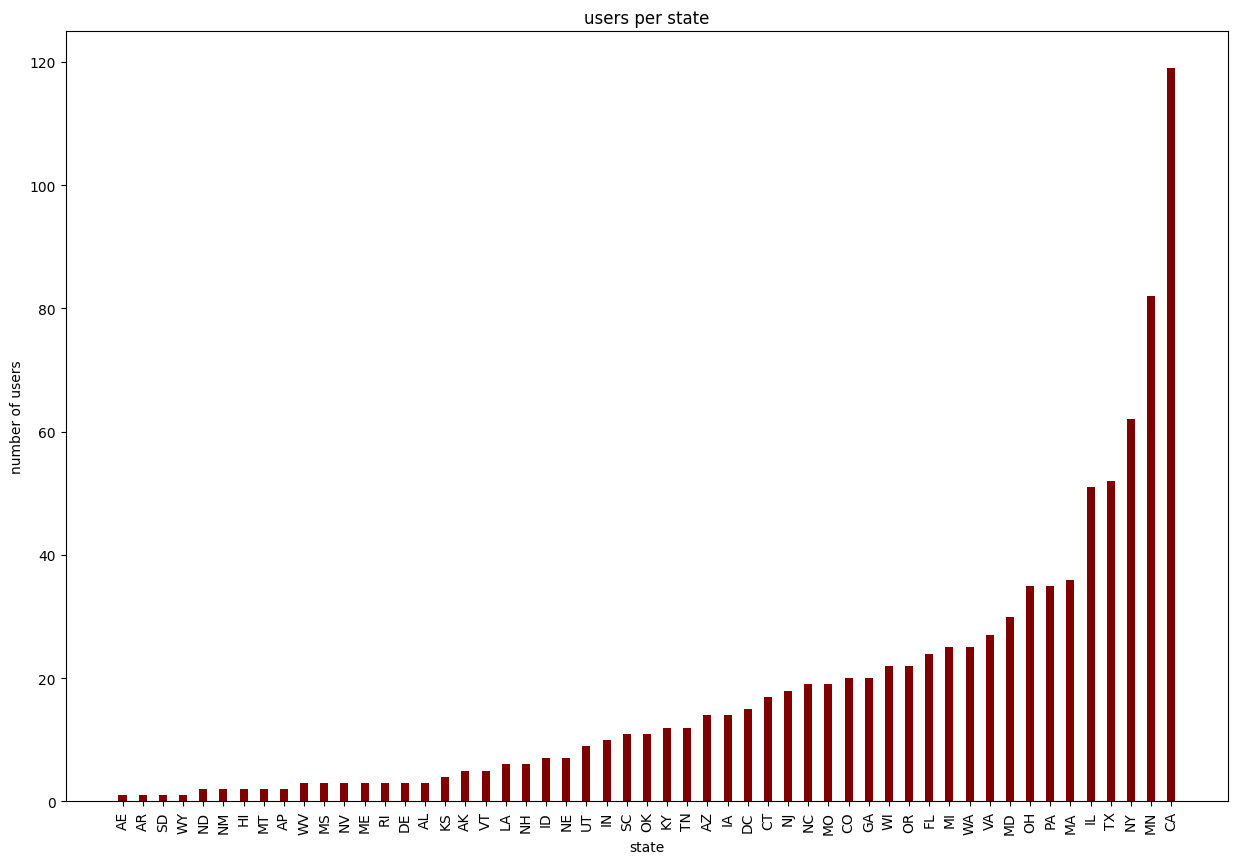

In [8]:
users_vc = users['state'].value_counts().sort_values(ascending=True)
vis.bar_plot(x=users_vc.index, y=users_vc.values, 
                   x_label='state', 
                   y_label='number of users', 
                   title='users per state', 
                   fig_size=(15, 10))

It might not be too simple to extract any useful insight since the number of states is indeed large and the number of users in each state is too low to guarantee statistical significance.

Even if 8 out of 10 users from the 'SC' state seem to assign extremely low ratings to romantic movies, it does not seem reasonable to generalize this observation on unseen data, mainly when the population is of size 10.

In [9]:
# it might be interesting to group users fro mthe least frequent into a single bin "other state"
users_vc = users['state'].value_counts()
users['state'] = users['state'].apply(lambda x: 'other' if users_vc[x] < 10 else x)
users['state'].value_counts()
users.drop(columns=['zip_code'], inplace=True)

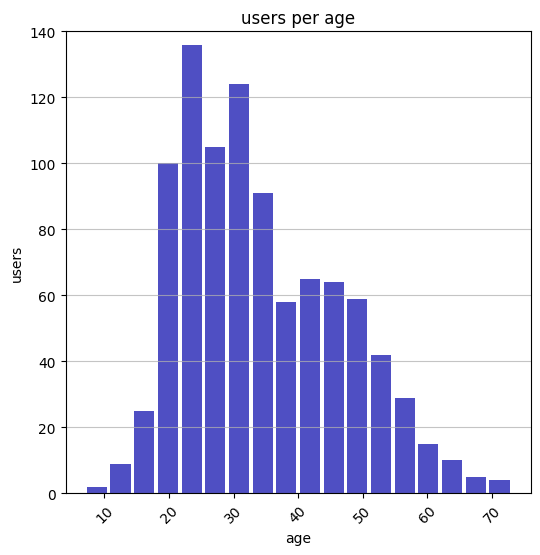

In [10]:
vis.plot_histogram(x=users['age'], x_label='age', y_label='users', title='users per age', fig_size=(6, 6))

We can see that the 'age' variable is approximately normally distributed.

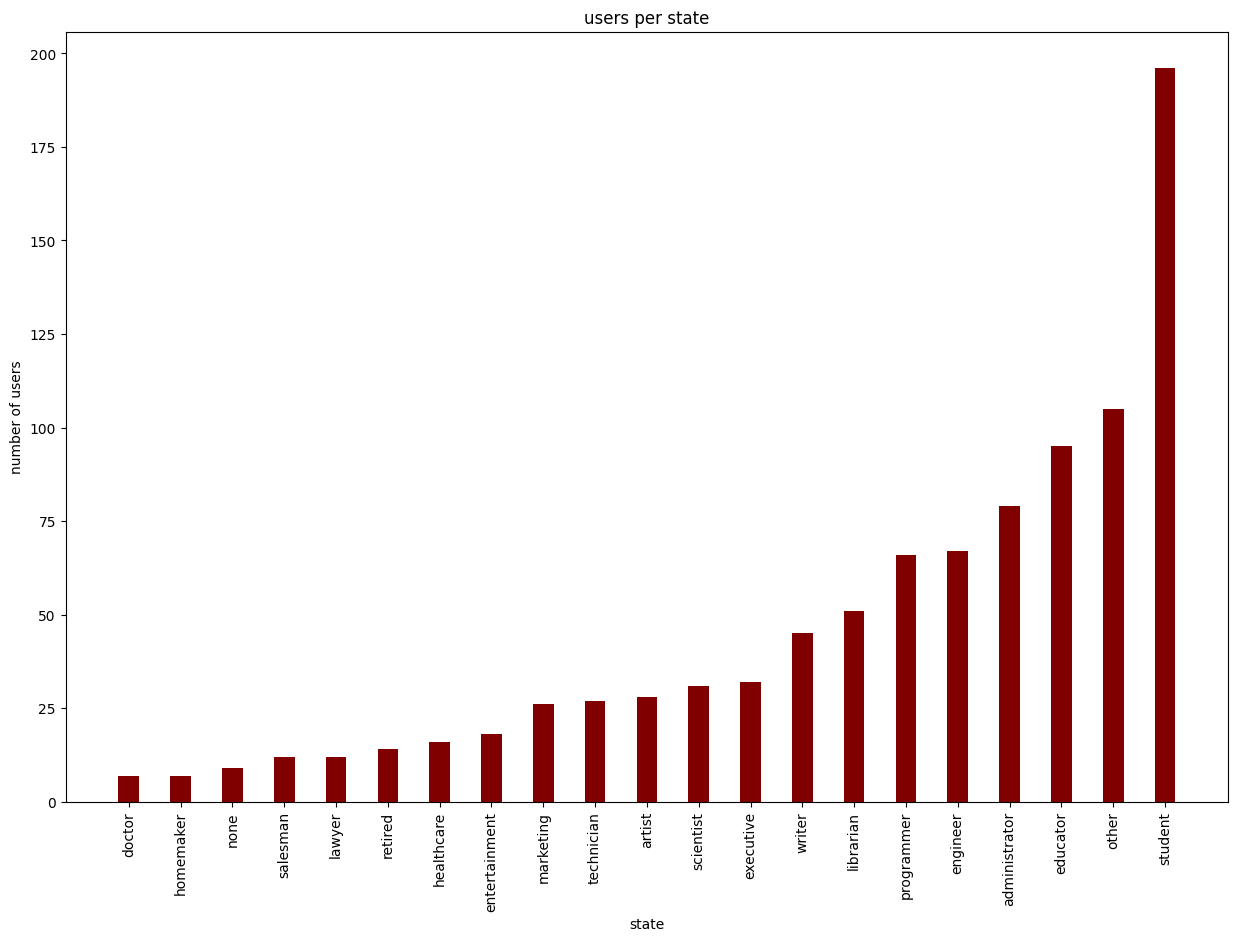

In [11]:
# let's understand the distribution of the jobs
jobs_vc = users['job'].value_counts().sort_values(ascending=True)
vis.bar_plot(x=jobs_vc.index, y=jobs_vc.values, 
                   x_label='state', 
                   y_label='number of users', 
                   title='users per state', 
                   fig_size=(15, 10))

The initial distirbution of 'jobs' is quite similar to that of states. However, grouping jobs seems much more promising / natural than grouping users based on their geolocation information. For example: 

* Engineers, programmers, doctors might be more interested in 'Comedy' movies than other genres 
* librarians, writers and artists might on average highly rate Documentary movies... 

This hypothesis can only verified or refuted by going through the ratings data

In [13]:
os.makedirs(os.path.join(DATA_FOLDER, 'prepared'), exist_ok=True)
users.to_csv(os.path.join(DATA_FOLDER, 'prepared', "users.csv"), index=False)